In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sys
import pickle
import matplotlib.pyplot as plt


% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Import data

In [14]:
base_features = pd.read_pickle('../data/processed/base_features.pkl')
text_features = pd.read_pickle('../data/processed/text_features.pkl')

In [29]:
all_features = pd.concat([base_features.reset_index(drop=True), text_features], axis=1)
target = all_features.pop('target')

In [30]:
print(np.shape(all_features))
all_features.head()

(36027, 1761)


,tweet_id,hour_created,weekday_created,photo_exists,tweet_sentiment,retweets_per_followers,favs_per_followers,rate_all_caps,retweet_count,favorite_count,...,yes,yesterday,yet,york,youll,young,youre,youth,yr,zero
0,954068125439463425,19,3,0,1,0.002015,0.001936,0.030303,76,73,...,False,False,False,False,False,False,False,False,False,False
1,954396450611441664,16,4,0,1,0.000371,0.001114,0.000000,14,42,...,False,False,False,False,False,False,False,False,False,False
2,954409153203703808,17,4,0,1,0.001538,0.003686,0.058824,58,139,...,False,False,False,False,False,False,False,False,False,False
3,954480752573460480,22,4,0,-1,0.000663,0.001034,0.055556,25,39,...,False,False,False,False,False,False,False,False,False,False
4,954504963501314048,0,5,1,0,0.001220,0.002254,0.090909,46,85,...,False,False,False,False,False,False,False,False,False,False


# Evaluate Model

In [31]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size=0.3, random_state=42)

In [72]:
def find_auc_ensemble(X_train, X_test, y_train, y_test, base_model, text_model):

    X_base_train = X_train.iloc[:,:11]
    X_base_test = X_test.iloc[:,:11]

    X_text_train = X_train.iloc[:,11:]
    X_text_test = X_test.iloc[:,11:]
    
    predictions = []
    
    def get_prediction(model, X_train, X_test):
        """
        Append probability prediction to list of predictions for ensembling
        """
        model.fit(X_train, np.ravel(y_train))
        y_predict = model.predict_proba(X_test)[:,1] 
        predictions.append(y_predict)
        
    get_prediction(base_model, X_base_train, X_base_test)
    get_prediction(text_model, X_text_train, X_text_test)
        
    y_score = [np.mean(e) for e in zip(*predictions)]

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot([0,1],[0,1]) # this is our baseline
    plt.plot(fpr, tpr) # this is our ROC curve
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    print('AUC: ', roc_auc)
    print(thresholds)

In [51]:
with open("../models/gcb_clf_base_features.pkl", "rb") as mdl:
    base_model = pickle.load(mdl)

In [46]:
with open("../models/nb_clf_text_features.pkl", "rb") as mdl:
    text_model = pickle.load(mdl)

AUC:  0.8897738050565027
[0.99954804 0.99123325 0.99064628 ... 0.01038965 0.0102956  0.00111849]


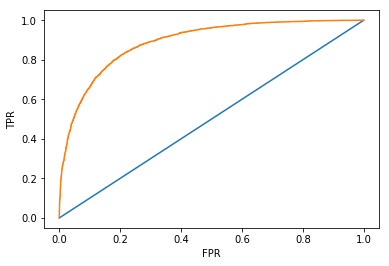

In [73]:
find_auc_ensemble(X_train, X_test, y_train, y_test, base_model, text_model)